In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm import tqdm
import helper
import configparser
import os

In [2]:
import importlib
importlib.reload(helper)

<module 'helper' from '/projetos/dx4o/pytorch/autoencoder/helper.py'>

In [47]:
# =====================
# GET CONFIG VARIABLES
# =====================

config = configparser.ConfigParser()
config.read('config.ini')

BatchSize = config.getint('TRAIN', 'BatchSize')
Epochs = config.getint('TRAIN', 'Epochs')
LearningRate = config.getfloat('TRAIN', 'LearningRate')
file = config.get('TRAIN', 'TrainFile')
device = config.get('TRAIN', 'Device')

dirname = os.path.dirname("__file__")
FILE_PATH = os.path.join(dirname, file)
DEVICE = device
BATCH_SIZE = BatchSize
EPOCHS = Epochs
LR = LearningRate

### EXPLORE DATASET

In [48]:
data = pd.read_csv(FILE_PATH)

In [49]:
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


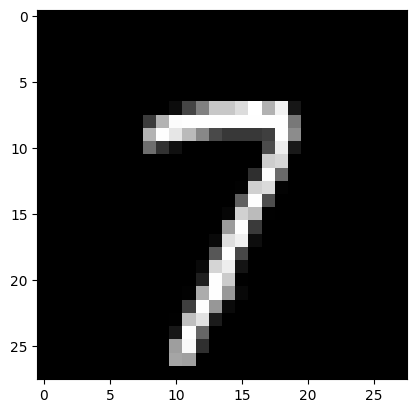

In [50]:
n = 18

image = data.iloc[n]
image = np.array(image).astype("float32")

# (784,) -> (28x28)
image = np.reshape(image, (28, 28))
image = image / 255.0

plt.imshow(image, cmap = "gray")

In [51]:
noisy_image = image + 0.2 * np.random.randn(*image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

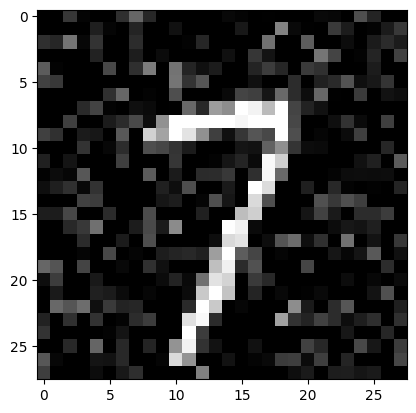

In [52]:
plt.imshow(noisy_image, cmap = "gray")

### DATA PREPARATION

In [53]:
class MNIST_AE_Dataset(Dataset):
    
    def __init__(self, csv_file, noise_factor=0.2, transform=None):
        
        self.data = pd.read_csv(csv_file)
        self.noise_factor = noise_factor
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        img = self.data.iloc[idx]
        img = np.array(img).astype("float32")
        
        img = np.reshape(img, (28, 28, 1)) / 255.0 # channel as 1
        
        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        
        sample = (img, noisy_img)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [54]:
# convert numpy/PIL to torch tensor and (H, W, C) to (C, H, W)

trainset = MNIST_AE_Dataset(FILE_PATH, transform=helper.ToTensorForAE())

In [55]:
print(f"Size of trainset: {len(trainset)}")

Size of trainset: 42000


In [56]:
n = 7
orig_img, noisy_img = trainset[n]

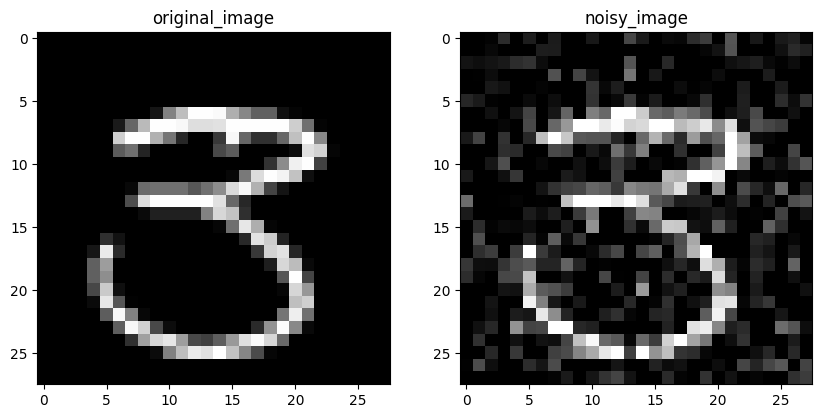

In [57]:
helper.show_image(orig_img.squeeze(), noisy_img.squeeze())

### LOAD DATA INTO BATCHES

In [58]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

In [59]:
for orig_img, noisy_img in trainloader:
    break
    
print(f"Shape of loading 1 batch: {noisy_img.shape}")
print(f"Total number of batches: {len(trainloader)}")
print(f"Total number of examples in trainloader: {len(trainloader.dataset)}")

Shape of loading 1 batch: torch.Size([16, 1, 28, 28])
Total number of batches: 2625
Total number of examples in trainloader: 42000


### DEFINE MODEL

In [66]:
def Encoder():
    
    enc = nn.Sequential(
        
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2))
        )
    return enc

In [67]:
def Decoder():
    
    dec = nn.Sequential(
        
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(2, 2), stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(2, 2), stride=2),
        nn.Sigmoid()
    )
    return dec


In [68]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, input_images):
        encoder_out = self.encoder(input_images)
        decoder_out = self.decoder(encoder_out)
        
        return decoder_out

In [70]:
model = AutoEncoder()
model.to(DEVICE)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [74]:
summary(model, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

### TRAIN AUTOENCODER MODEL

In [77]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = nn.MSELoss()

In [79]:
for i in range(EPOCHS):
    
    train_loss = 0.0
    
    model.train()
    for batch in tqdm(trainloader):
        
        orig_image, noisy_image = batch
        
        orig_image = orig_image.to(DEVICE)
        noisy_image = noisy_image.to(DEVICE)

        denoised_image = model(noisy_image)
        loss = criterion(denoised_image, orig_image)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(trainloader)
    
    print(f"Epoch: {i+1} - Train Loss: {avg_train_loss}")

100%|██████████| 2625/2625 [00:13<00:00, 195.81it/s]


Epoch: 1 - Train Loss: 0.009194015241627182


100%|██████████| 2625/2625 [00:13<00:00, 194.88it/s]


Epoch: 2 - Train Loss: 0.005300719009978431


100%|██████████| 2625/2625 [00:13<00:00, 199.36it/s]


Epoch: 3 - Train Loss: 0.005048173863706844


100%|██████████| 2625/2625 [00:13<00:00, 196.41it/s]


Epoch: 4 - Train Loss: 0.004880338758851091


100%|██████████| 2625/2625 [00:13<00:00, 195.48it/s]


Epoch: 5 - Train Loss: 0.004760646193332615


100%|██████████| 2625/2625 [00:13<00:00, 193.49it/s]


Epoch: 6 - Train Loss: 0.004655125891346307


100%|██████████| 2625/2625 [00:13<00:00, 200.32it/s]


Epoch: 7 - Train Loss: 0.0045936181487604266


100%|██████████| 2625/2625 [00:12<00:00, 208.05it/s]


Epoch: 8 - Train Loss: 0.004547956461973843


100%|██████████| 2625/2625 [00:13<00:00, 193.10it/s]


Epoch: 9 - Train Loss: 0.004516336400150543


100%|██████████| 2625/2625 [00:13<00:00, 194.11it/s]


Epoch: 10 - Train Loss: 0.00447587684258109


100%|██████████| 2625/2625 [00:13<00:00, 195.30it/s]


Epoch: 11 - Train Loss: 0.004462183341029145


100%|██████████| 2625/2625 [00:13<00:00, 193.97it/s]


Epoch: 12 - Train Loss: 0.004425537407753013


100%|██████████| 2625/2625 [00:13<00:00, 193.35it/s]


Epoch: 13 - Train Loss: 0.004411996831496557


100%|██████████| 2625/2625 [00:13<00:00, 195.11it/s]


Epoch: 14 - Train Loss: 0.004397941252571486


100%|██████████| 2625/2625 [00:13<00:00, 194.52it/s]


Epoch: 15 - Train Loss: 0.004383843171809401


100%|██████████| 2625/2625 [00:13<00:00, 197.66it/s]


Epoch: 16 - Train Loss: 0.004375068030187062


100%|██████████| 2625/2625 [00:13<00:00, 192.44it/s]


Epoch: 17 - Train Loss: 0.004365602945731509


100%|██████████| 2625/2625 [00:13<00:00, 191.36it/s]


Epoch: 18 - Train Loss: 0.004354568768647455


100%|██████████| 2625/2625 [00:13<00:00, 200.22it/s]


Epoch: 19 - Train Loss: 0.004342729977465102


100%|██████████| 2625/2625 [00:13<00:00, 193.99it/s]


Epoch: 20 - Train Loss: 0.0043384991237627605


100%|██████████| 2625/2625 [00:13<00:00, 194.98it/s]


Epoch: 21 - Train Loss: 0.004335231950506568


100%|██████████| 2625/2625 [00:13<00:00, 199.40it/s]


Epoch: 22 - Train Loss: 0.004325452825852802


100%|██████████| 2625/2625 [00:13<00:00, 195.39it/s]


Epoch: 23 - Train Loss: 0.004314492090472153


100%|██████████| 2625/2625 [00:10<00:00, 254.47it/s]


Epoch: 24 - Train Loss: 0.004315048646891401


100%|██████████| 2625/2625 [00:13<00:00, 195.33it/s]

Epoch: 25 - Train Loss: 0.0043096807071318225


### PLOT RESULTS

Shape of denoised images: torch.Size([1, 1, 28, 28]) 


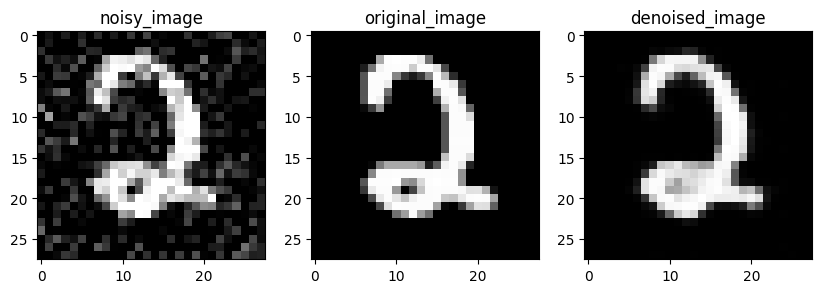

In [138]:
model.eval()
model.to(DEVICE)

with torch.no_grad():

    dataiter = iter(trainloader)
    sample = next(dataiter)
    
    orig_image, noisy_image = sample

    idx = 2

    orig_image = orig_image.to(DEVICE)
    noisy_image = noisy_image.to(DEVICE)

    denoised_image = model(noisy_image[idx].unsqueeze(0)) # (c ,h, w) -> (batch, c, h, w)

    print(f"Shape of denoised images: {denoised_image.shape} ")

    helper.show_image(orig_image[idx].squeeze(0), 
                      noisy_image[idx].squeeze(0), 
                      denoised_image[0].squeeze(0))